# 전통적 시계열 모델링

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다. 
* 발주 최적화를 위한 수요량 예측 : 1일후의 판매량을 예측

![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성 

* 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

* 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

## (3) Data Loading

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[(data['date']>= '2013-06-01') & (data['date']< '2015-03-01')].reset_index(drop = True)
data.head(10)

,date,item,sales,tot_sales,comp_sales
0,2013-06-01,28,124,1016,80
1,2013-06-02,28,139,1019,93
2,2013-06-03,28,77,676,65
3,2013-06-04,28,93,764,80
4,2013-06-05,28,117,818,80
5,2013-06-06,28,112,881,71
6,2013-06-07,28,127,929,81
7,2013-06-08,28,105,925,78
8,2013-06-09,28,129,998,95
9,2013-06-10,28,103,710,74


* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

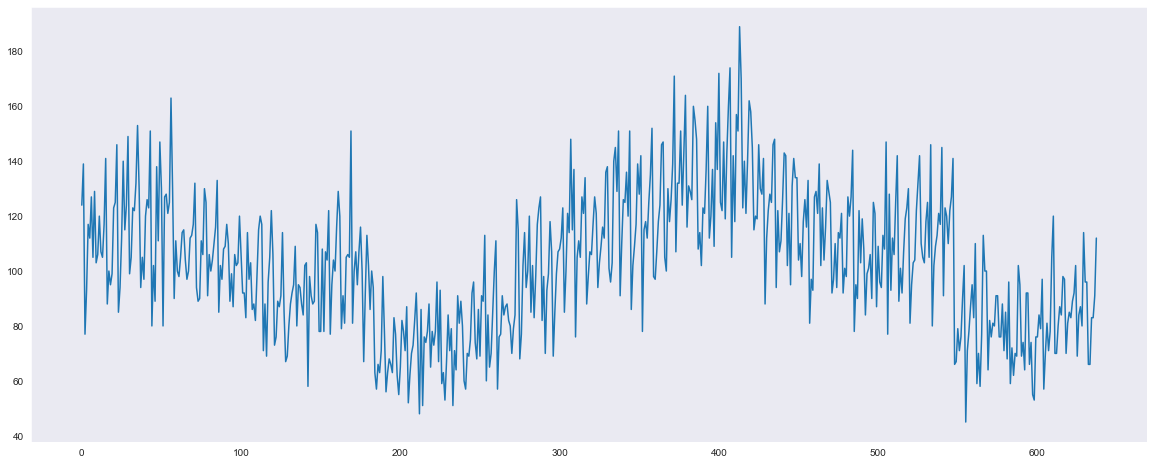

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [6]:
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,item,sales,tot_sales,comp_sales,y
0,2013-06-01,28,124,1016,80,139.0
1,2013-06-02,28,139,1019,93,77.0
2,2013-06-03,28,77,676,65,93.0
3,2013-06-04,28,93,764,80,117.0
4,2013-06-05,28,117,818,80,112.0


,date,item,sales,tot_sales,comp_sales,y
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0
637,2015-02-28,28,112,774,77,NaN


In [7]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,item,sales,tot_sales,comp_sales,y
632,2015-02-23,28,66,488,43,66.0
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0


## (2) Feature Engineering
* 필요한 변수들을 도출해 봅시다.

## (3) 데이터 분할

### 1) x, y 나누기

In [8]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False) 
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기
* k-fold cross validation for Time Seires : TimeSeriesSplit

In [9]:
# 여기서는 1회 분할로 진행합니다.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

# 3.모델링1 : ARIMA

## (1) y 값 살펴보기

* 정규성 검정(> 0.05) :  0.00746
* 정상성 검정(< 0.05) :  0.54662
* 자기상관성 확인(ACF, PACF)


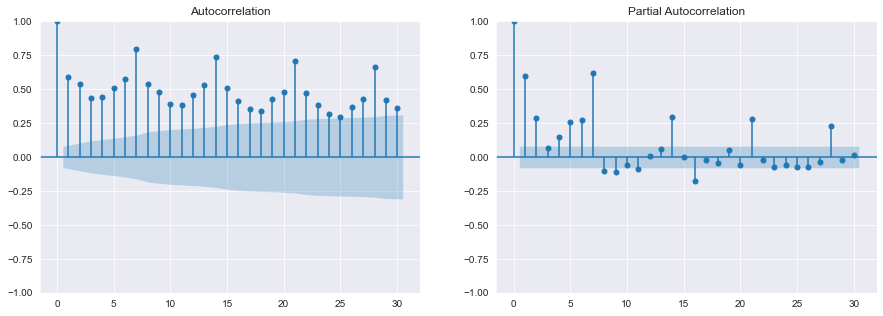

In [10]:
residual_diag(y_train, lags=30)

## (2) 모델링 : 초기모델

* p, d, q 값을 어떻게 정해야 할까요?
* AR의 p 차수와 MA q 차수 모두 값이 필요해 보입니다. 일단 1, 1을 지정합시다.

### 1) 학습

* sm.tsa.SARIMAX(train, order=(p,d,q)).fit()
    * 모델 선언시 train이 포함
    * .fit()으로 학습.

In [13]:
m1 = sm.tsa.SARIMAX(endog=y_train, order=(1,1,1)).fit()

### 2) 평가

#### ① 잔차진단

* 모델.resid : 잔차를 뽑을 수 있습니다.
* 위에서 만든 함수 residual_diag 를 사용하여 잔차진단을 해 봅시다.

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  1e-05
* 자기상관성 확인(ACF, PACF)


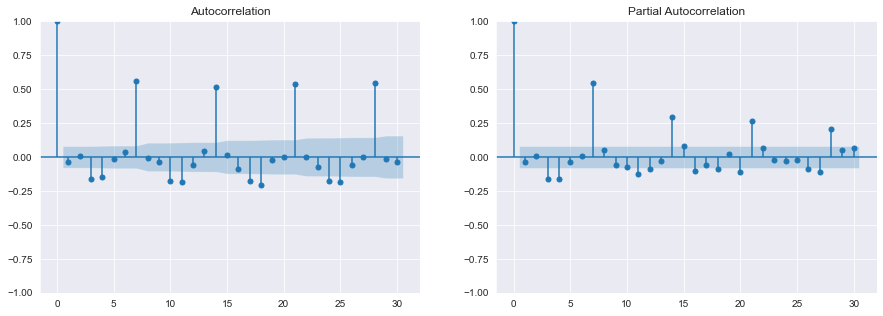

In [14]:
residual_diag(m1.resid)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수
* SARIMAX 모델.aic로 쉽게 통계량을 구할 수 있습니다.

In [15]:
print(m1.aic)

5226.970492639296


#### ③ Validation

시계열 데이터로 실제값과 예측값에 대해 비교하여 그래프를 그려봅시다.

In [16]:
pred = m1.forecast(30)

In [17]:
print(f'MAE: {mean_absolute_error(y_val, pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred)}')

MAE: 14.898867116526409
MAPE: 0.15780557365356912


* 결과 시각화

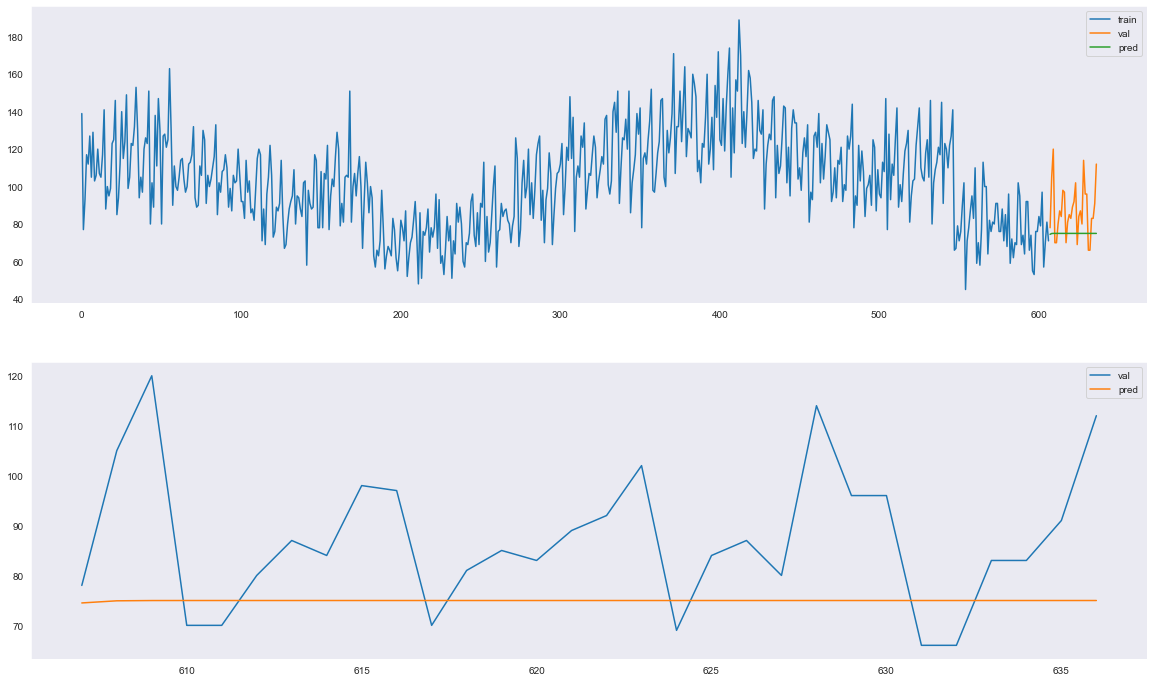

In [19]:
plot_model_result(y_train, y_val, pred)

## (3) 하이퍼파라미터 튜닝

실제로 p, d, q를 찾는 과정은 마치 Grid Search 처럼 값을 조금씩 조정해가며  최적의 모델을 찾아가는 과정과 유사합니다.


### 1) 학습

In [20]:
from itertools import product

* 값의 범위 지정
    * 시간이 많이 소요될 수 있으니 범위를 적절하게 지정하세요.

In [56]:
# product 함수를 이용하여 값의 조합을 구성
p = [_ for _ in range(1, 10)]
q = [_ for _ in range(1, 10)]
d = [_ for _ in range(1, 2)]
iter = list(product(p,d,q))
iter

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 1, 8),
 (1, 1, 9),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (2, 1, 8),
 (2, 1, 9),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (3, 1, 7),
 (3, 1, 8),
 (3, 1, 9),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (4, 1, 7),
 (4, 1, 8),
 (4, 1, 9),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (5, 1, 7),
 (5, 1, 8),
 (5, 1, 9),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6),
 (6, 1, 7),
 (6, 1, 8),
 (6, 1, 9),
 (7, 1, 1),
 (7, 1, 2),
 (7, 1, 3),
 (7, 1, 4),
 (7, 1, 5),
 (7, 1, 6),
 (7, 1, 7),
 (7, 1, 8),
 (7, 1, 9),
 (8, 1, 1),
 (8, 1, 2),
 (8, 1, 3),
 (8, 1, 4),
 (8, 1, 5),
 (8, 1, 6),
 (8, 1, 7),
 (8, 1, 8),
 (8, 1, 9),
 (9, 1, 1),
 (9, 1, 2),
 (9, 1, 3),
 (9, 1, 4),
 (9, 1, 5),
 (9, 1, 6),
 (9, 1, 7),
 (9, 1, 8),
 (9, 1, 9)]

* 튜닝

In [57]:
# 
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(1, 1, 6)
(1, 1, 7)
(1, 1, 8)
(1, 1, 9)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(2, 1, 5)
(2, 1, 6)
(2, 1, 7)
(2, 1, 8)
(2, 1, 9)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(3, 1, 5)
(3, 1, 6)
(3, 1, 7)
(3, 1, 8)
(3, 1, 9)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)
(4, 1, 5)
(4, 1, 6)
(4, 1, 7)
(4, 1, 8)
(4, 1, 9)
(5, 1, 1)
(5, 1, 2)
(5, 1, 3)
(5, 1, 4)
(5, 1, 5)
(5, 1, 6)
(5, 1, 7)
(5, 1, 8)
(5, 1, 9)
(6, 1, 1)
(6, 1, 2)
(6, 1, 3)
(6, 1, 4)
(6, 1, 5)
(6, 1, 6)
(6, 1, 7)
(6, 1, 8)
(6, 1, 9)
(7, 1, 1)
(7, 1, 2)
(7, 1, 3)
(7, 1, 4)
(7, 1, 5)
(7, 1, 6)
(7, 1, 7)
(7, 1, 8)
(7, 1, 9)
(8, 1, 1)
(8, 1, 2)
(8, 1, 3)
(8, 1, 4)
(8, 1, 5)
(8, 1, 6)
(8, 1, 7)
(8, 1, 8)
(8, 1, 9)
(9, 1, 1)
(9, 1, 2)
(9, 1, 3)
(9, 1, 4)
(9, 1, 5)
(9, 1, 6)
(9, 1, 7)
(9, 1, 8)
(9, 1, 9)


In [58]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
69,"(8, 1, 7)",6.656668,4848.806631


,"params(p,d,q)",mae,aic
61,"(7, 1, 8)",10.252482,4768.381965


In [60]:
# 가장 성능이 좋은 p, d, q 값으로 모델을 생성합니다.

m2 = sm.tsa.SARIMAX(endog=y_train, order=(7, 1, 8)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


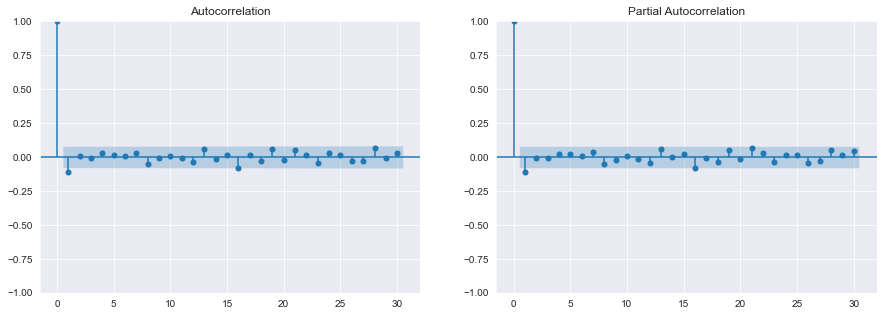

In [61]:
residual_diag(m2.resid)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [62]:
print(m2.aic)

4768.3819647525725


#### ③ Validation

In [63]:
pred = m1.forecast(30)

print(f'MAE: {mean_absolute_error(y_val, pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred)}')

MAE: 14.898867116526409
MAPE: 0.15780557365356912


* 결과 시각화

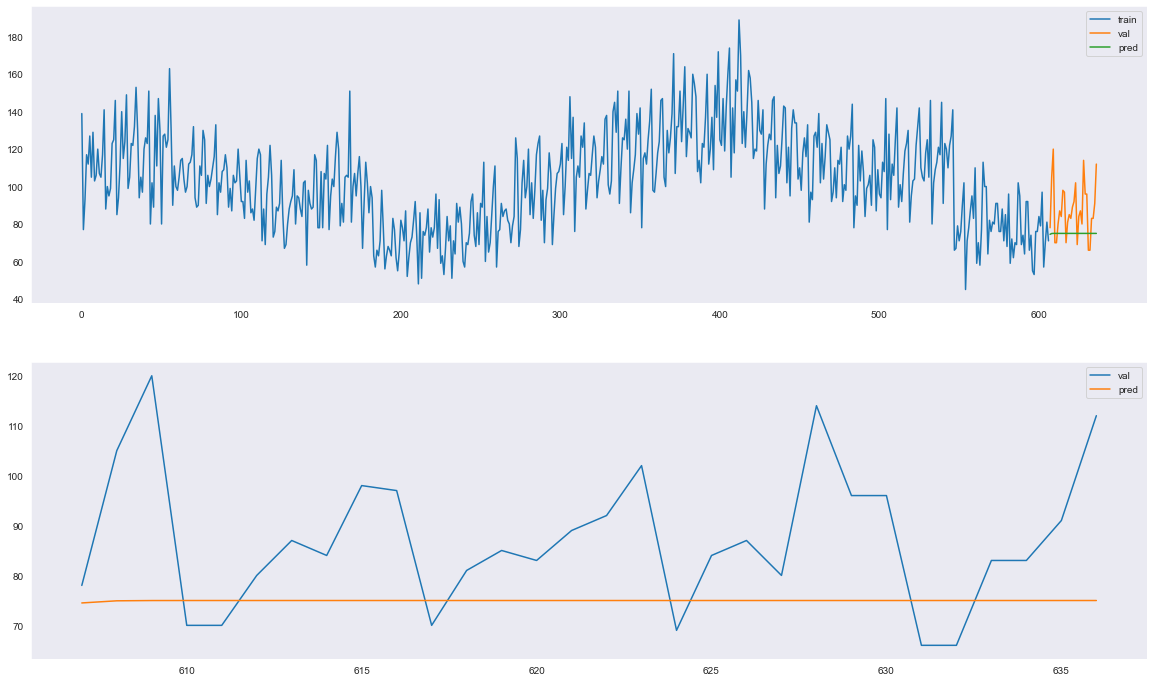

In [64]:
plot_model_result(y_train, y_val, pred)

# 4.모델링2 : SARIMA

## (1) 모델링 : 초기모델

### 1) 학습

In [65]:
# SARIMA 모델링 : P, D, Q, m = 1,1,1,7 로 모델을 생성합시다.

m2_1 = sm.tsa.SARIMAX(y_train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 7)).fit()

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


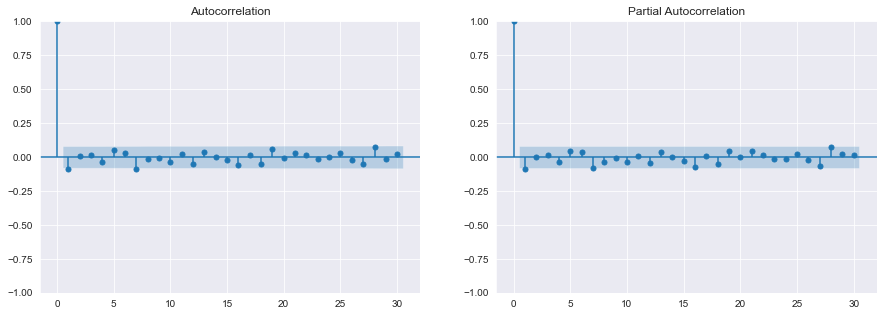

In [67]:
residual_diag(m2_1.resid)

#### ② AIC

In [68]:
print(m2_1.aic)

4673.47226585438


#### ③ Validation

* 결과 시각화

## (2) 하이퍼파라미터 튜닝
* 너무 큰 범위를 지정하면 시간이 많이 걸립니다.
    * D는 1로 고정
    * P, Q는 1 ~ 4 사이에서 결정

### 1) 학습

In [ ]:
p = [1, 2, 3, 4, 5]
q = [1, 2, 3, 4, 5]
P = [1, 2, 3, 4, 5]
Q = [1, 2, 3, 4, 5]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q,p,q))

for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[3], 1, i[4]), seasonal_order=(i[0],i[1],i[2],7)).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1, 1, 1)
(1, 1, 1, 1, 2)
(1, 1, 1, 1, 3)
(1, 1, 1, 1, 4)
(1, 1, 1, 1, 5)
(1, 1, 1, 2, 1)
(1, 1, 1, 2, 2)
(1, 1, 1, 2, 3)
(1, 1, 1, 2, 4)
(1, 1, 1, 2, 5)
(1, 1, 1, 3, 1)
(1, 1, 1, 3, 2)
(1, 1, 1, 3, 3)
(1, 1, 1, 3, 4)
(1, 1, 1, 3, 5)
(1, 1, 1, 4, 1)
(1, 1, 1, 4, 2)
(1, 1, 1, 4, 3)
(1, 1, 1, 4, 4)
(1, 1, 1, 4, 5)
(1, 1, 1, 5, 1)
(1, 1, 1, 5, 2)
(1, 1, 1, 5, 3)
(1, 1, 1, 5, 4)
(1, 1, 1, 5, 5)
(1, 1, 2, 1, 1)
(1, 1, 2, 1, 2)
(1, 1, 2, 1, 3)
(1, 1, 2, 1, 4)
(1, 1, 2, 1, 5)
(1, 1, 2, 2, 1)
(1, 1, 2, 2, 2)
(1, 1, 2, 2, 3)
(1, 1, 2, 2, 4)
(1, 1, 2, 2, 5)
(1, 1, 2, 3, 1)
(1, 1, 2, 3, 2)
(1, 1, 2, 3, 3)
(1, 1, 2, 3, 4)
(1, 1, 2, 3, 5)
(1, 1, 2, 4, 1)
(1, 1, 2, 4, 2)
(1, 1, 2, 4, 3)
(1, 1, 2, 4, 4)
(1, 1, 2, 4, 5)
(1, 1, 2, 5, 1)
(1, 1, 2, 5, 2)
(1, 1, 2, 5, 3)
(1, 1, 2, 5, 4)
(1, 1, 2, 5, 5)
(1, 1, 3, 1, 1)
(1, 1, 3, 1, 2)
(1, 1, 3, 1, 3)
(1, 1, 3, 1, 4)
(1, 1, 3, 1, 5)
(1, 1, 3, 2, 1)
(1, 1, 3, 2, 2)
(1, 1, 3, 2, 3)
(1, 1, 3, 2, 4)
(1, 1, 3, 2, 5)
(1, 1, 3, 3, 1)
(1, 1, 3, 3, 2)
(1, 1, 3

In [ ]:
result = pd.DataFrame({'params(P,D,Q,p,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

In [ ]:
# 가장 성능이 좋은 P, D, Q 값으로 모델을 생성합니다.
m2_2 = sm.tsa.SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(3,1,3,7)).fit()
m2_3 = sm.tsa.SARIMAX(y_train, order=(3, 1, 3), seasonal_order=(1,1,1,7)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


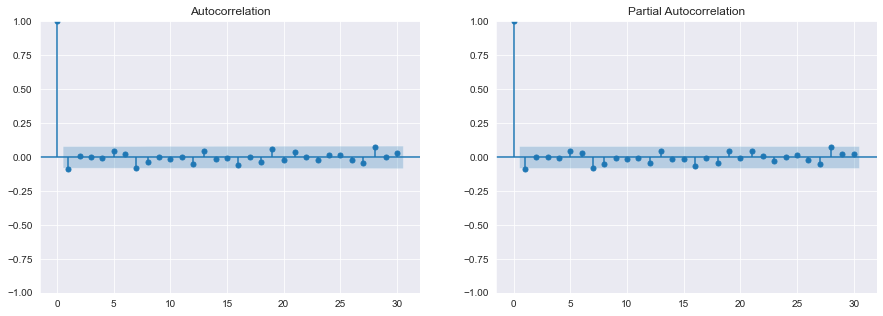

In [87]:
residual_diag(m2_2.resid)

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


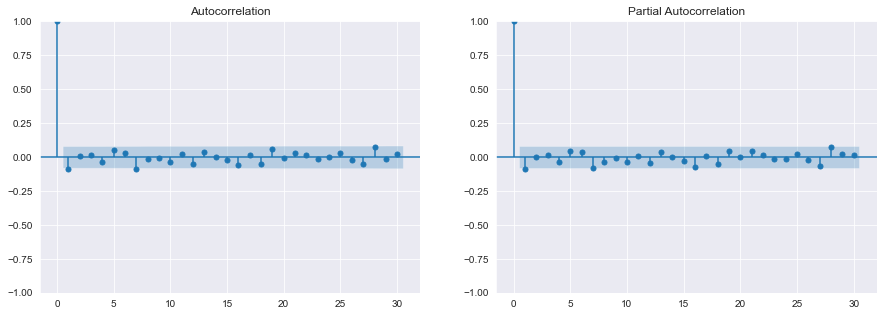

In [88]:
residual_diag(m2_3.resid)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [89]:
print(m2_2.aic)
print(m2_3.aic)

4681.983089266583
4673.47226585438


#### ③ Validation

In [90]:
pred2_2 = m2_2.forecast(30)
pred2_3 = m2_3.forecast(30)

print(f'm2_2 MAE: {mean_absolute_error(y_val, pred2_2)}')
print(f'm2_2 MAPE: {mean_absolute_percentage_error(y_val, pred2_2)}')

print(f'm2_3 MAE: {mean_absolute_error(y_val, pred2_3)}')
print(f'm2_3 MAPE: {mean_absolute_percentage_error(y_val, pred2_3)}')

m2_2 MAE: 10.083247348446424
m2_2 MAPE: 0.11404046147362337
m2_3 MAE: 10.968659049823389
m2_3 MAPE: 0.12408527209917504


* 결과 시각화

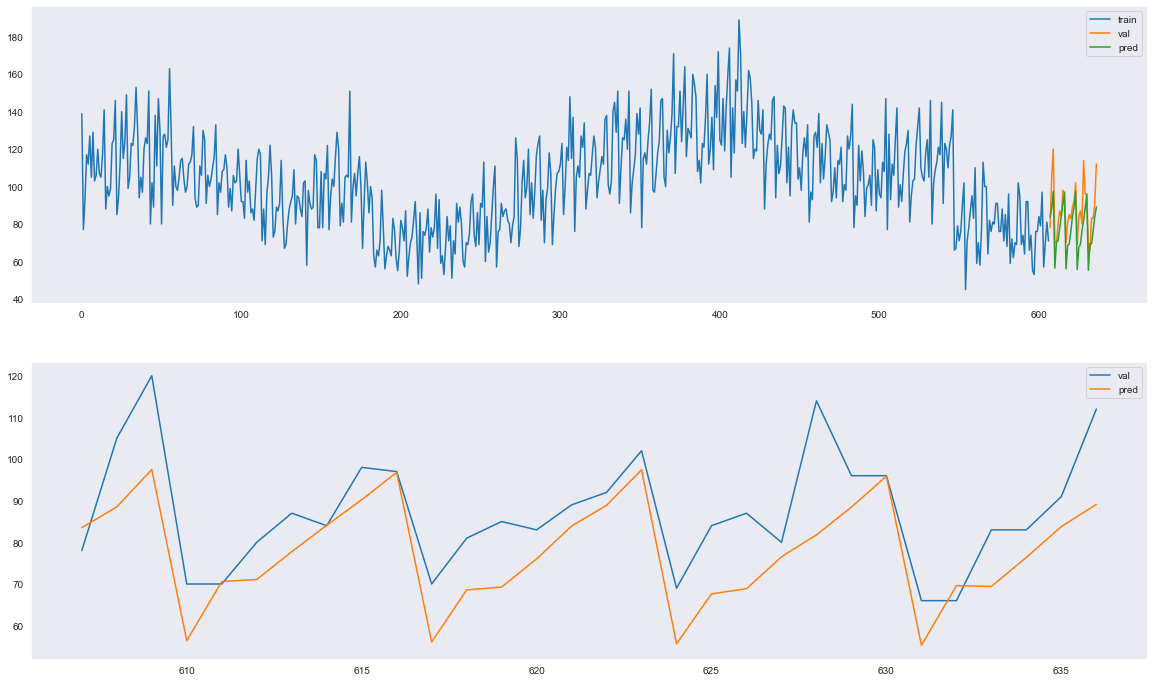

In [91]:
plot_model_result(y_train, y_val, pred2_2)

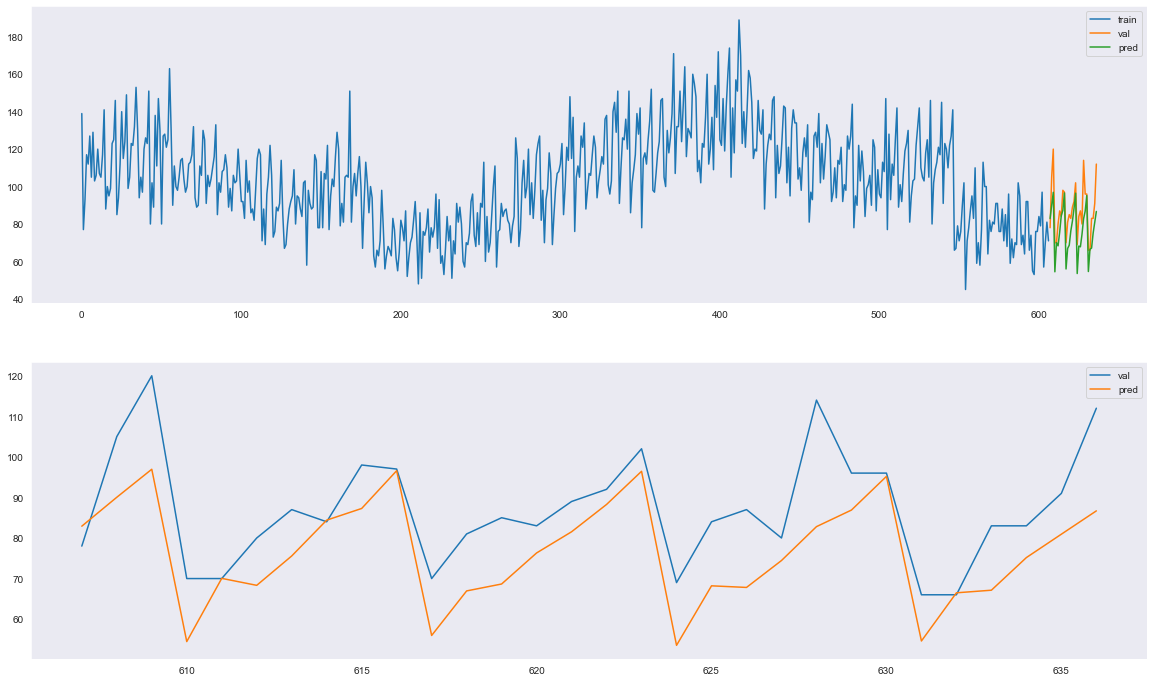

In [92]:
plot_model_result(y_train, y_val, pred2_3)

# 5.모델링3 : SARIMAX

## (1) 모델링

### 1) 학습
* 위에서 찾은 차수(p,d,q, P,D,Q,m) 에 x_train을 넣어 모델링해 봅시다.

In [ ]:
m3_1 = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=(3, 1, 3), seasonal_order=(1,1,1,7)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

In [ ]:
residual_diag(m3_1.resid)

#### ② AIC

In [ ]:
print(m3_1.aic)

#### ③ Validation
SARIMAX 모델을 생성하고, 예측할 때는 exog=x_val 옵션이 들어가야 함.

In [ ]:
pred3_1 = m3_1.forecast(30, exog=x_val)

print(f'MAE: {mean_absolute_error(y_val, pred3_1)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred3_10)}')

* 결과 시각화

In [ ]:
plot_model_result(y_train,y_val,pred3_1)